## Error correction model
- vector error correction model (VECM) is a restricted VAR designed for use with nonstationary series that are known to be cointegrated
- cointegration relations built into the specification so that it restricts the long-run behavior of the endogenous variables to converge to their cointegrating relationships while allowing for short-run adjustment dynamics
-  cointegration term is known as the error correction term since the deviation from long-run equilibrium is corrected gradually through a series of partial short-run adjustments.
- Our series have nonzero means and deterministic trends as well as stochastic trends

In [1]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat
import glob
plt.style.use('dark_background')

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("April_data_6series.csv")
df.sample(5)

<IPython.core.display.Javascript object>

Unnamed: 0            timestamp        es     eurusd     gbpusd  \
14156       14156  2020-05-15 01:54:00  2841.375  1080245.0  1221220.0   
8670         8670  2020-05-11 06:28:00  2934.375  1084405.0  1241290.0   
20211       20211  2020-05-21 09:48:00  2949.125  1096635.0  1222980.0   
9323         9323  2020-05-11 17:21:00  2931.875  1081190.0  1234845.0   
12916       12916  2020-05-14 05:14:00  2808.750  1080890.0  1220805.0   

            gc        nq       usdjpy  
14156  1741.95  9071.500  107276000.0  
8670   1707.65  9245.625  106993500.0  
20211  1733.95  9435.375  107780000.0  
9323   1700.80  9297.250  107691500.0  
12916  1721.65  8986.875  106861500.0

In [3]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.tail()

timestamp       es     eurusd     gbpusd       gc        nq  \
29340  2020-05-29 20:56:00  3027.25  1111740.0  1235400.0  1731.50  9588.625   
29341  2020-05-29 20:57:00  3027.25  1111750.0  1235450.0  1731.20  9588.500   
29342  2020-05-29 20:58:00  3027.25  1111650.0  1235450.0  1731.45  9588.625   
29343  2020-05-29 20:59:00  3027.25  1113400.0  1235450.0  1731.30  9587.375   
29344  2020-05-29 21:00:00  3027.25  1113400.0  1237150.0  1731.35  9591.125   

            usdjpy  
29340  107675000.0  
29341  107830000.0  
29342  107830000.0  
29343  107835000.0  
29344  107835000.0

In [4]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [5]:
X = df[:15000] # subset of data
X

es     eurusd     gbpusd       gc        nq  \
timestamp                                                                
2020-05-01 00:00:00  2877.125  1094465.0  1258140.0  1695.85  8846.125   
2020-05-01 00:01:00  2875.375  1094215.0  1257935.0  1695.60  8841.250   
2020-05-01 00:02:00  2874.625  1094165.0  1257765.0  1695.65  8837.750   
2020-05-01 00:03:00  2874.125  1094115.0  1257565.0  1695.40  8836.750   
2020-05-01 00:04:00  2875.250  1094190.0  1257535.0  1694.85  8841.125   
...                       ...        ...        ...      ...       ...   
2020-05-15 15:53:00  2821.125  1081390.0  1212205.0  1755.70  8973.500   
2020-05-15 15:54:00  2822.625  1081685.0  1212850.0  1755.95  8976.500   
2020-05-15 15:55:00  2825.875  1081830.0  1213105.0  1756.25  8988.000   
2020-05-15 15:56:00  2827.625  1082185.0  1213390.0  1757.15  8991.625   
2020-05-15 15:57:00  2827.625  1081960.0  1212960.0  1756.80  8991.500   

                          usdjpy  
timestamp                         
2020-05-01 00:00:00  107301000.0  
2020-05-01 00:01:00  107368000.0  
2020-05-01 00:02:00  107376500.0  
2020-05-01 00:03:00  107381500.0  
2020-05-01 00:04:00  107376500.0  
...                          ...  
2020-05-15 15:53:00  107285000.0  
2020-05-15 15:54:00  107285000.0  
2020-05-15 15:55:00  107290000.0  
2020-05-15 15:56:00  107258000.0  
2020-05-15 15:57:00  107267000.0  

[15000 rows x 6 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

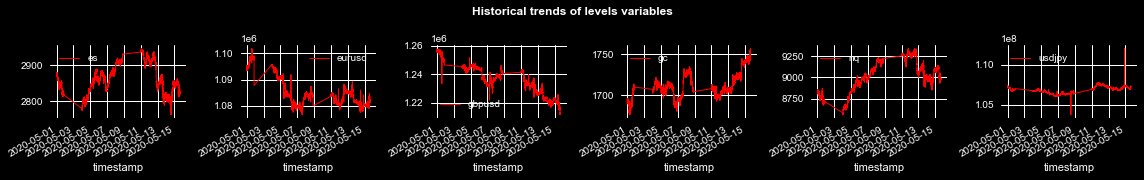

In [86]:
plt.style.use('dark_background')
def plot_vars(train, levels, color, leveltype):
    
    """
    Displays historical trends of variables
    And see if it's sensible to just select levels instead of differences
    """
    fig, ax = plt.subplots(1, 6, figsize=(16,2.5), sharex=True)
    for col, i in dict(zip(levels, list(range(6)))).items():
        X[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
    
    fig.suptitle(f"Historical trends of {leveltype} variables", 
                 fontsize=12, fontweight="bold")
    
plot_vars(X.values, levels = X.columns, color="red", leveltype="levels")
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

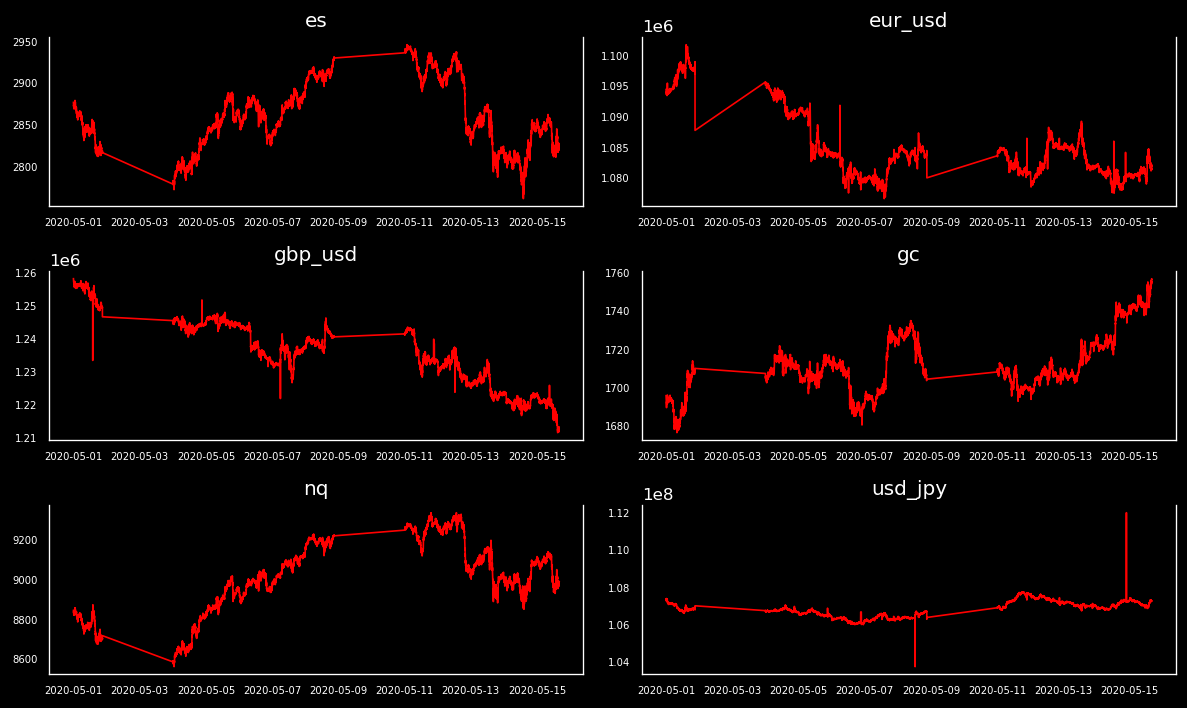

In [6]:
# Plot
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    dataset = X[X.columns[i]]
    ax.plot(dataset, color='red', linewidth=1)
    # Decorations
    ax.set_title(X.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

We have seen earler (VAR model) that all the series are unit root non-stationary, they may be co-integrated. This extension of unit root concept to multiple time series means that a liner combination of two or more series is stationary and hence, mean reverting. We also have seen that, VAR model is not equipped to handle this case without differencing. So, we will use here Vector Error Correction Model (VECM). We will explore here cointegratyion becase , if present and assumed to pressist, it can be leveraged for trading strategy.

However, the concept of an integrated multivariate series is complicated by the fact that, all the component series of the process may be individually integrated but the process is not jointly integrated in the sense that one or more linear combinations of the series exist that produce a new stationary series.

To simplify, a combination of two co-integrated series has a stable mean to which this linear combination reverts. A multivariate series with this characteristics is said to be cointegrated.

### Test for cointegartion
To verify further the relevance of the model, there is need to test for cointegration. In order to assume a long run relationship in the model despite the fact that the series are drifting apart or trending either upward or downward? having a long-run equilibrium.

Note: Cointegration test should be performed on the level form of the variables and not on their first difference. Both tests are performed as shown below.

There are two major approaches to test for cointegration:
- Engle-Granger twio step method
- Johansen procedure

Engle-Granger method involves regressing one series over another and then applying ADF unit root test to the regression residual. If H0 (null hypothesis) can be rejected, then we can assume that residuals are stationary and the series are cointegrated. A benefot of this approach is that, the regression cofficient represents  the multiplier that renders the combinationn stationary i.e. mean reverting.

Johansen procedure tests the restrictions imposed by cointegration on a VAR model. 

### Johansen co-integration on level data:
Johansen test assesses the validity of a cointegrating relationship, using a maximum likelihood estimates (MLE) approach.

Two types of Johansen’s test:

- one uses trace (from linear algebra),
- the other a maximum eigenvalue approach (an eigenvalue is a special scalar; when we multiply a matrix by a vector and get the same vector as an answer, along with a new scalar, the scalar is called an eigenvalue).
- Both forms of the test will determine if cointegration is present. The hypothesis is stated as:

Null hypothesis (H0) for both: no cointegrating equations.

The difference is in the alternate hypothesis (H1): the trace test alternate hypothesis is simply that the number of cointegrating relationships is at least one (shown by the number of linear combinations).

Rejecting the null hypothesis is basically stating there is only one combination of the non-stationary variables that gives a stationary process.

In [6]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import CointRankResults

In [7]:
nobs = 15
train_ecm, test_ecm = X[0:-nobs], X[-nobs:]

# Check size
print(train_ecm.shape)  
print(test_ecm.shape)

(14985, 6)
(15, 6)


In [8]:
# VECM model fitting
from statsmodels.tsa.vector_ar import vecm
# pass "1min" frequency
train_ecm.index = pd.DatetimeIndex(train_ecm.index).to_period('1min')
model = vecm.select_order(train_ecm, maxlags=8)
print(model.summary())

<IPython.core.display.Javascript object>

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       45.14       45.16   4.006e+19       45.14
1       44.94       44.98   3.298e+19       44.96
2       44.87      44.93*   3.071e+19       44.89
3       44.86       44.94   3.041e+19       44.89
4       44.85       44.95   3.019e+19      44.89*
5       44.85       44.97   3.018e+19       44.89
6       44.85       44.98   3.015e+19       44.90
7       44.85       45.00   3.013e+19       44.90
8      44.85*       45.02  3.012e+19*       44.91
-------------------------------------------------


In [10]:
pd.options.display.float_format = "{:.2f}".format
"""definition of det_orderint:
-1 - no deterministic terms; 0 - constant term; 1 - linear trend"""
pd.options.display.float_format = "{:.2f}".format
model = coint_johansen(endog = train_ecm, det_order = 1, k_ar_diff = 3)
print('Eigen statistic:')
print(model.eig) 
print()
print('Critical values:')
d = DataFrame(model.cvt)
d.rename(columns = {0:'90%', 1: '95%', 2:'99%'}, inplace=True)
print(d); print()
print('Trace statistic:')
print(DataFrame(model.lr1)) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Eigen statistic:
[1.04952026e-02 2.94113957e-03 1.52293361e-03 8.61024360e-04
 6.18626590e-04 8.31512622e-05]

Critical values:
     90%    95%    99%
0 102.47 107.34 116.98
1  75.10  79.34  87.77
2  51.65  55.25  62.52
3  32.06  35.01  41.08
4  16.16  18.40  23.15
5   2.71   3.84   6.63

Trace statistic:
       0
0 248.44
1  90.38
2  46.25
3  23.42
4  10.52
5   1.25


Here, we see that trace statistics (76.86033757  44.90556245  24.43779121  11.11437692) are < critical values @95% (79.24, 55.24, 35.01, 18.39).

Interpreting Johansen Cointegration Test Results
- output releases two statistics, Trace Statistic and Max-Eigen Statistic
- Rejection criteria is at 0.05 level
- Reject (H0) null hypothesis if the p-value <= 0.05 means there is no cointegrating equations.

### Eigen and Trace statistic (Johansent co-integration)

In [10]:
pd.options.display.float_format = "{:.2f}".format
model = coint_johansen(endog = df, det_order = 0, k_ar_diff = 8)

print("\nnormalized eigenvector 0\n", model.evec[:,0] / model.evec[:,0][0])
print("\nnormalized eigenvector 1\n", model.evec[:,1] / model.evec[:,1][0])
print("\ntest statistics\n", model.lr1[0], model.lr1[1]) # Trace statistic
print("\ncritical values\n", model.cvt[0], model.cvt[1]) # Maximum eigenvalue statistic
print("\neig\n", model.eig)  # Eigenvalues of VECM coefficient matrix
print("\nevec\n", model.evec)  # Eigenvectors of VECM coefficient matrix
print("\nlr1\n", model.lr1)  # dim = (n,) Trace statistic
print("\nlr2\n", model.lr2) 
print("\ncvt\n", model.cvt) # Critical values (90%, 95%, 99%) of trace statistic
print("\ncvm\n", model.cvm) # Critical values (90%, 95%, 99%) of maximum eigenvalue statistic
print("\nind\n", model.ind) # Order of eigenvalues

<IPython.core.display.Javascript object>


normalized eigenvector 0
 [ 1.00000000e+00 -1.28099738e-02  8.52789191e-03  1.21507909e+00
 -5.47916544e-01  4.18535043e-04]

normalized eigenvector 1
 [ 1.00000000e+00 -5.77393675e-03  5.42036754e-03  3.02286576e+00
 -2.96545096e-02 -3.76238235e-06]

test statistics
 223.65261025071345 69.59540232505341

critical values
 [ 91.109   95.7542 104.9637] [65.8202 69.8189 77.8202]

eig
 [5.23770799e-03 1.06822476e-03 6.92215965e-04 3.95860840e-04
 1.89995071e-04 2.51508322e-05]

evec
 [[ 8.27454198e-03  1.93989277e-02  4.50876970e-02 -1.61530048e-03
   3.65505444e-02 -6.73818655e-03]
 [-1.05996666e-04 -1.12008181e-04 -9.24086151e-05 -2.18865531e-05
  -3.16979511e-05  1.36891964e-04]
 [ 7.05643996e-05  1.05149318e-04 -1.38118572e-04 -3.51522270e-05
  -9.23987742e-06 -2.75895990e-05]
 [ 1.00542230e-02  5.86403542e-02  9.21519414e-03 -4.56043506e-02
  -8.74999395e-03  8.71288218e-03]
 [-4.53375845e-03 -5.75265687e-04 -1.35882374e-02  4.12811125e-03
  -9.83616206e-03  6.80052062e-04]
 [ 3.4631

In [19]:
# simplifying the above test statotistic in tabular format as below
# trace test

out = coint_johansen(endog = df, det_order = 1, k_ar_diff = 8)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d['0.95']]
def adjust(val, length= 6): return str(val).ljust(length)
print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
for col, trace, cvt in zip(df.columns, traces, cvts):
    print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
es     ::  231.01    > 107.3429  =>   True
eurusd ::  76.86     > 79.3422   =>   False
gbpusd ::  44.91     > 55.2459   =>   False
gc     ::  24.44     > 35.0116   =>   False
nq     ::  11.11     > 18.3985   =>   False
usdjpy ::  4.91      > 3.8415    =>   True


We can see that in 4 equations, we can safely reject null hypotheses and alternate hypotheses of cointegration exists are accepted.

In [21]:
# eigen test

out = coint_johansen(endog = df, det_order = 1, k_ar_diff = 8)
d = {'0.90':0, '0.95':1, '0.99':2}
eigen = out.eig
cvts = out.cvt[:, d['0.95']]
def adjust(val, length= 6): return str(val).ljust(length)
print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
for col, eig, cvt in zip(df.columns, eigen, cvts):
    print(adjust(col), ':: ', adjust(round(eig,2), 9), ">", adjust(cvt, 8), ' =>  ' , eig > cvt)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
es     ::  0.01      > 107.3429  =>   False
eurusd ::  0.0       > 79.3422   =>   False
gbpusd ::  0.0       > 55.2459   =>   False
gc     ::  0.0       > 35.0116   =>   False
nq     ::  0.0       > 18.3985   =>   False
usdjpy ::  0.0       > 3.8415    =>   False


- Implies that the series in question are related and therefore can be combined in a linear fashion.
- That is, even if there are shocks in the short run, which may affect movement in the individual series, they would converge with time (in the long run).
- Estimate both long-run and short-run models.
- moving together in such a way that their linear combination results in a stationary time series
- sharing an underlying common stochastic trend.

Here we can safely use of vector autoregressive (VAR) model and vector error correction model (VECM) for analysis. Cointegration implies that time series will be connecting through an error correction model. The error correction model is important in time series analysis because it allows us to better understand long-run dynamics.

### Engle Granger cointegration test:

This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

The output returns

- t-statistic of unit-root test on residuals.
- asymptotic p-value based on MacKinnon (1994).
- critical values for the test statistic at the 1 %, 5 %, and 10 % levels 

The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

In [13]:
import statsmodels.tsa.stattools as ts 

print('EURUSD <-> GBPUSD')
print(ts.coint(df.eur_usd, df.gbp_usd))
print('_________________')
print('EURUSD <-> USDJPY')
print(ts.coint(df.eur_usd, df.usd_jpy))
print('_________________')
print('EURUSD <-> GC')
print(ts.coint(df.eur_usd, df.gc))
print('_________________')
print('EURUSD <-> NQ')
print(ts.coint(df.eur_usd, df.nq))
print('_________________')
print('EURUSD <-> ES')
print(ts.coint(df.eur_usd, df.es))
print('_________________')

EURUSD <-> GBPUSD
(-0.0011403985334112684, 0.9858737322331019, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> USDJPY
(-1.5924783837568488, 0.7240542800072871, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> GC
(-0.14712854722883298, 0.9818312116557436, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> NQ
(-1.0104216635072174, 0.900852773183557, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> ES
(-1.4367130551767546, 0.7846522688207963, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


###### p-value in all cases of 0.98/0.72/0.98/0.90/0.78 > 0.05 means that the null hypothesis (H0) of no cointegration cannot be rejected at the 5% level of significance. 

In [14]:
print('USDJPY <-> GBPUSD')
print(ts.coint(df.usd_jpy, df.gbp_usd))
print('_________________')
print('USDJPY <-> EURUSD')
print(ts.coint(df.usd_jpy, df.eur_usd))
print('_________________')
print('USDJPY <-> GC')
print(ts.coint(df.usd_jpy, df.gc))
print('_________________')
print('USDJPY <-> NQ')
print(ts.coint(df.usd_jpy, df.nq))
print('_________________')
print('USDJPY <-> ES')
print(ts.coint(df.usd_jpy, df.es))
print('_________________')

USDJPY <-> GBPUSD
(-2.65851960139799, 0.21485079967488957, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> EURUSD
(-2.7335777184796006, 0.18773511918419344, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> GC
(-2.470029631202671, 0.2924443884820324, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> NQ
(-3.6763180047935626, 0.019649938803279452, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> ES
(-3.043635909526089, 0.10019394372482177, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


##### p-values in all 5 cases of 0.21/0.18/0.29/0.10 > 0.05 means that the null hypothesis (H0) of no cointegration cannot be rejected at the 5% level of significance. In one case (USDJPY <-> NQ, we find p (0.01) < 0.05 means that H1 is accepted means cointegrating relationships in these series.

In [15]:
print('GBPUSD <-> EURUSD')
print(ts.coint(df.gbp_usd, df.eur_usd))
print('_________________')
print('GBPUSD <-> USDJPY')
print(ts.coint(df.gbp_usd, df.usd_jpy))
print('_________________')
print('GBPUSD <-> GC')
print(ts.coint(df.gbp_usd, df.gc))
print('_________________')
print('GBPUSD <-> NQ')
print(ts.coint(df.gbp_usd, df.nq))
print('_________________')
print('GBPUSD <-> ES')
print(ts.coint(df.gbp_usd, df.es))
print('_________________')

GBPUSD <-> EURUSD
(-2.661696713977882, 0.21365617053342362, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> USDJPY
(-3.073544211862579, 0.09374098979586265, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> GC
(-3.449728926421366, 0.03711966187765066, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> NQ
(-2.5444315084440174, 0.25983270044418083, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> ES
(-2.6170426599316086, 0.23002022844736103, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


##### Here too, in one case (GBPUSD<-> GC, we find p-value (0.03) < 0.05, which means that H1 is accepted and cointegrating relationships in these series.

In [16]:
print('NQ <-> EURUSD')
print(ts.coint(df.nq, df.eur_usd))
print('_________________')
print('NQ <-> USDJPY')
print(ts.coint(df.nq, df.usd_jpy))
print('_________________')
print('NQ <-> GC')
print(ts.coint(df.nq, df.gc))
print('_________________')
print('NQ <-> GBPUSD')
print(ts.coint(df.nq, df.gbp_usd))
print('_________________')
print('NQ <-> ES')
print(ts.coint(df.nq, df.es))
print('_________________')

NQ <-> EURUSD
(-2.0852499341943584, 0.48407934078997517, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> USDJPY
(-3.396820345256975, 0.04270486157388667, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> GC
(-1.358088338509924, 0.811518066596494, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> GBPUSD
(-1.5402802879835626, 0.745424526392285, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> ES
(-2.3876194948368843, 0.330740895233771, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


In [60]:
nobs = 15
train_ecm, test_ecm = X[0:-nobs], X[-nobs:]

# Check size
print(train_ecm.shape)  
print(test_ecm.shape)

(14985, 6)
(15, 6)


# Linear model assumptions:
- model in linear in parameters
- regressors are fixed, non-stochastic
- expected value of error term is 0
- homoscedastic or constant variance of errors
- no auto-correlation
- no multi-colinearity; no perfect linear relationships among Xs
- no specification bias

Gaus-Markov theorem:
- given all above assumptions
  - estimators are liner functions of the dependent variable (y)
  - estimators are unbiased, in repeated samples, the estimators approach their true value
  - in the class of linear estimators, OLS estimators have minimum variance; i.e they are efficient, or the best estimators.

In [61]:
# VECM model fitting
from statsmodels.tsa.vector_ar import vecm
# pass "1min" frequency
train_ecm.index = pd.DatetimeIndex(train_ecm.index).to_period('1min')
model = vecm.select_order(train_ecm, maxlags=8)
print(model.summary())

<IPython.core.display.Javascript object>

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       45.14       45.16   4.006e+19       45.14
1       44.94       44.98   3.298e+19       44.96
2       44.87      44.93*   3.071e+19       44.89
3       44.86       44.94   3.041e+19       44.89
4       44.85       44.95   3.019e+19      44.89*
5       44.85       44.97   3.018e+19       44.89
6       44.85       44.98   3.015e+19       44.90
7       44.85       45.00   3.013e+19       44.90
8      44.85*       45.02  3.012e+19*       44.91
-------------------------------------------------


## Error correction model:

- shows the long-run equilibrium relationships of variables.
- includes a short-run dynamic adjustment mechanism that describes how variables adjust when they are out of equilibrium.
- uses adjustment coefficients to measure the forces that push the relationship towards long-run equilibrium.

### Cointegration rank of a VECM

In [19]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [68]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank1 = select_coint_rank(train_ecm, det_order = 1, k_ar_diff = 3,
                                   method = 'trace', signif=0.01)
print(rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          248.4          117.0
  1   6          90.38          87.77
  2   6          46.25          62.52
-------------------------------------


- first column in the table shows the rank which is the number of cointegrating relationships for the dataset, while the second reports the number of equations in total. 
- λtrace statistics in the third column, together with the corresponding critical values. 
- first row of the table tests the null hypothesis of at most one cointegrating vector, against the alternative hypothesis that the number of cointegrating equations is strictly larger than the number assumed under the null hypothesis, i.e., larger than one. 
- test statistic of 254.9 considerably exceeds the critical value (117.0) and so the null of at most one cointegrating vector is rejected. 
- test statistic (89.92) also exceeds the critical value (87.77), so the null of at most two cointegrating vectors is rejected at the 1% level
- test statistic (48.59) do not exceeds the critical value (62.52), so the null of at most three cointegrating vectors cannot be rejected at the 1% level

Below test statistic on maximum eigen value:

Maximum-eigenvalue statistic assumes a given number of r cointegrating relations under the null hypothesis and tests this against the alternative that there are r + 1 cointegrating equations.

In [67]:
rank2 = select_coint_rank(train_ecm, det_order = 1, k_ar_diff = 3, 
                              method = 'maxeig', signif=0.01)

print(rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          158.1          49.41
  1   2          44.13          42.86
  2   3          22.83          36.19
-------------------------------------


In [69]:
from statsmodels.tsa.vector_ar.vecm import VECM
# VECM
vecm = VECM(train_ecm, k_ar_diff=3, coint_rank = 3, deterministic='ci')
"""estimates the VECM on the prices with 3 lags, 3 cointegrating relationship, and 
a constant within the cointegration relationship"""
vecm_fit = vecm.fit()
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation es
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.es          0.0235      0.019      1.232      0.218      -0.014       0.061
L1.eurusd   9.795e-05   4.54e-05      2.159      0.031    9.02e-06       0.000
L1.gbpusd  -2.588e-05   2.97e-05     -0.872      0.383   -8.41e-05    3.23e-05
L1.gc         -0.0052      0.019     -0.278      0.781      -0.042       0.031
L1.nq          0.0043      0.006      0.738      0.461      -0.007       0.016
L1.usdjpy  -7.006e-07   1.53e-07     -4.588      0.000      -1e-06   -4.01e-07
L2.es         -0.0391      0.019     -2.042      0.041      -0.077      -0.002
L2.eurusd      0.0005   4.67e-05     11.633      0.000       0.000       0.001
L2.gbpusd  -6.827e-05   3.13e-05     -2.179      0.029      -0.000   -6.85e-06
L2.gc         -0.0302      0.019     -1.626      


## Checking residual auto-correlation

In [70]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_fit.resid)
for col, val in zip(train_ecm.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.01
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0


## Impact of changes in one variable on the others at different horizons:

### Impulse Response Analysis
IRAs the estimated responses to a unit impulse in one of the variables. They are computed in practice using the MA(\infty) representation of the VAR(p) process:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

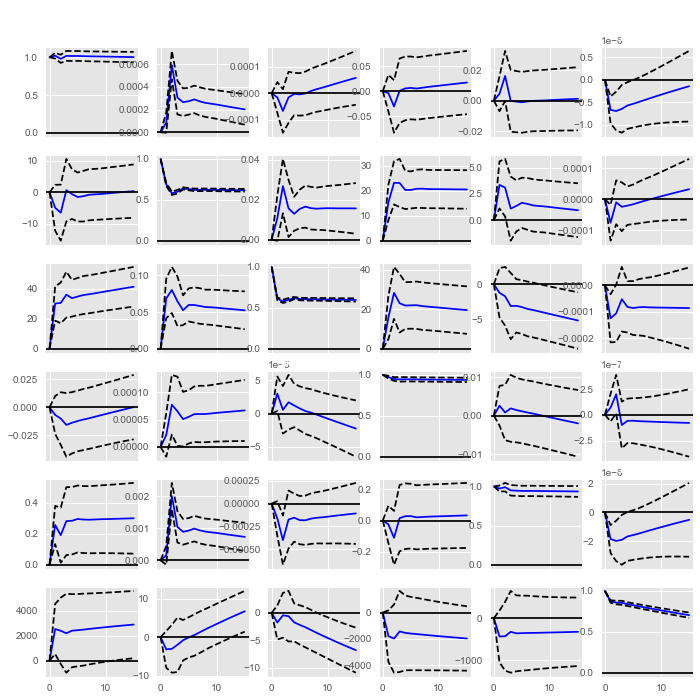

In [87]:
# stores and prints the impulse response functions
plt.style.use('ggplot')
irf = vecm_fit.irf(15)
irf.plot(orth = False)
plt.show()

#### Objectives: 
- how variable x effects variable y
- when the maximum impact is experienced
- how long the effect lasts

One standard deviation shock/increase to x causes significant increases (decreases) in y (impulse variable) for m periods (determined by the length of period for which the SE bands are above 0 or below 0 in case of decrease) after which the effect dissipates. The increase peaks in period k. 

Each of the IRF graphs tells us how a shock to one variable affects another (or the same) variable.

In [92]:
X.tail(1)

es     eurusd     gbpusd      gc      nq       usdjpy
timestamp                                                                     
2020-05-15 15:57:00 2827.62 1081960.00 1212960.00 1756.80 8991.50 107267000.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

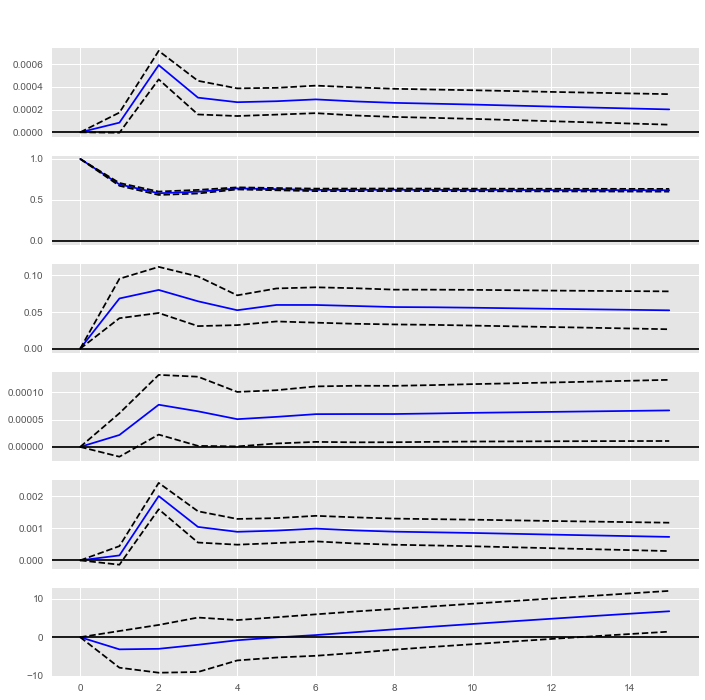

In [89]:
plt.style.use('ggplot')
irf.plot(impulse='eurusd')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

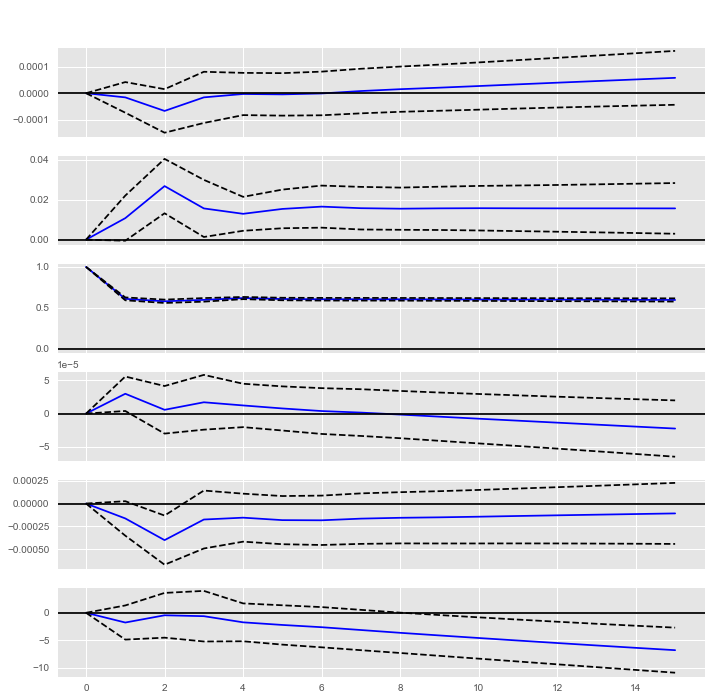

In [90]:
plt.style.use('ggplot')
irf.plot(impulse='gbpusd')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

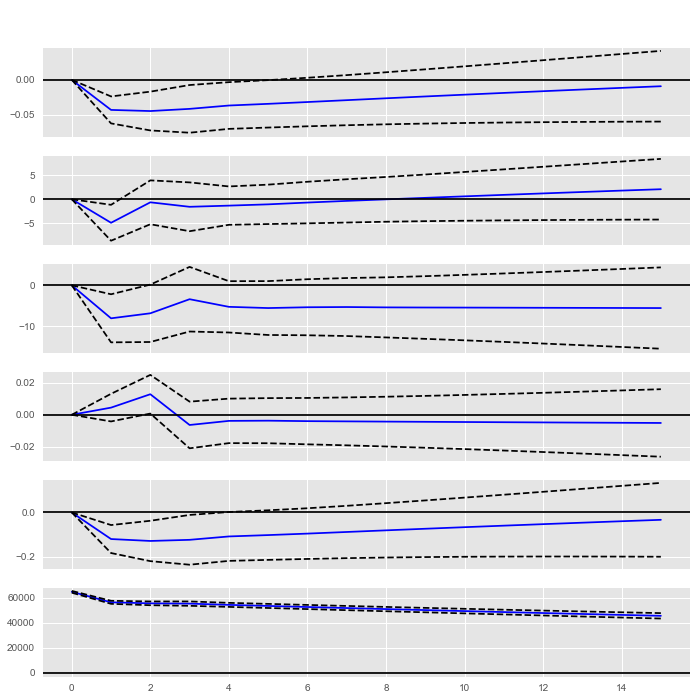

In [91]:
plt.style.use('ggplot')
irf.plot(impulse='usdjpy', orth = True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

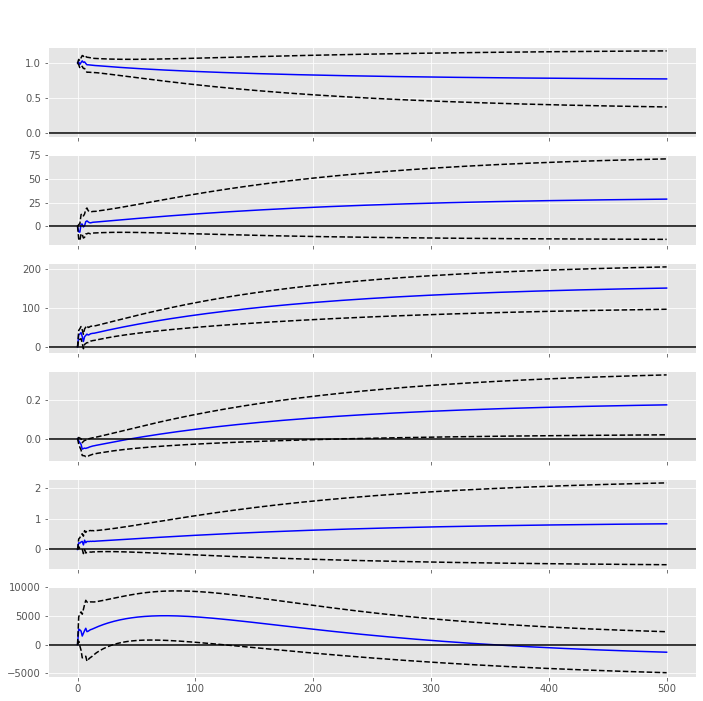

In [28]:
plt.style.use('ggplot')
irf.plot(impulse='es')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

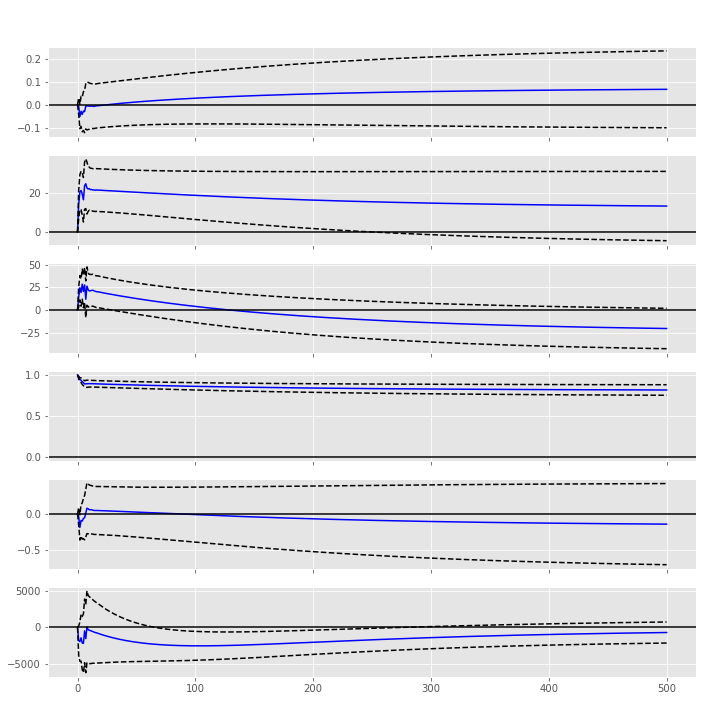

In [29]:
plt.style.use('ggplot')
irf.plot(impulse='gc')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

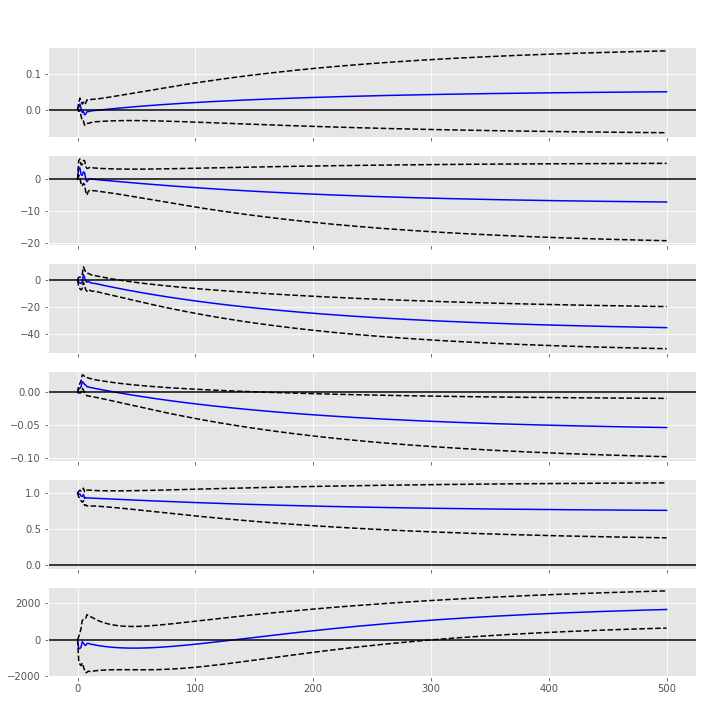

In [30]:
plt.style.use('ggplot')
irf.plot(impulse='nq')
plt.show()

In [32]:
eg = vecm_fit.test_granger_causality(caused="eur_usd", causing="gbp_usd")
eg.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [33]:
je = vecm_fit.test_granger_causality(caused="usd_jpy", causing="eur_usd")
je.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [34]:
jnq = vecm_fit.test_granger_causality(caused="usd_jpy", causing="nq")
jnq.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
jes = vecm_fit.test_granger_causality(caused="usd_jpy", causing="es")
jes.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [71]:
pd.options.display.float_format = "{:.2f}".format
forecast, lower, upper = vecm_fit.predict(nobs, 0.05)
print("lower bounds of confidence intervals:")
print(DataFrame(lower.round(2)))
print("\npoint forecasts:")
print(DataFrame(forecast.round(2)))
print("\nupper bounds of confidence intervals:")
print(DataFrame(upper.round(2)))

<IPython.core.display.Javascript object>

lower bounds of confidence intervals:
         0          1          2       3       4            5
0  2817.22 1081006.74 1211561.53 1754.12 8959.26 107147036.20
1  2816.13 1080905.78 1211440.30 1753.73 8955.87 107107152.97
2  2815.31 1080842.24 1211342.66 1753.46 8953.31 107077619.20
3  2814.59 1080781.27 1211252.25 1753.24 8951.13 107052471.30
4  2813.96 1080720.92 1211172.35 1753.05 8949.22 107030968.88
5  2813.38 1080666.47 1211100.55 1752.88 8947.49 107012107.55
6  2812.84 1080616.94 1211034.70 1752.72 8945.89 106995296.70
7  2812.34 1080570.33 1210973.82 1752.58 8944.41 106980125.01
8  2811.86 1080526.16 1210917.20 1752.45 8943.02 106966301.13
9  2811.41 1080484.32 1210864.18 1752.33 8941.70 106953616.84
10 2810.97 1080444.52 1210814.29 1752.22 8940.44 106941910.30
11 2810.56 1080406.47 1210767.15 1752.11 8939.24 106931053.24
12 2810.16 1080369.97 1210722.45 1752.01 8938.09 106920942.73
13 2809.77 1080334.89 1210679.94 1751.92 8936.98 106911494.52
14 2809.39 1080301.09 1210639.39

In [72]:
pd.options.display.float_format = "{:.2f}".format
forecast = DataFrame(forecast, index= test_ecm.index, columns= test_ecm.columns)
forecast.rename(columns = {'eurusd':'eurusd_pred', 'gbpusd':'gbpusd_pred', 'usdjpy':'usdjpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
forecast

<IPython.core.display.Javascript object>

es_pred  eurusd_pred  gbpusd_pred  gc_pred  nq_pred  \
timestamp                                                                  
2020-05-15 15:43:00  2819.58   1081467.48   1212277.02  1755.19  8967.01   
2020-05-15 15:44:00  2819.53   1081469.18   1212294.51  1755.22  8967.05   
2020-05-15 15:45:00  2819.50   1081471.41   1212308.00  1755.26  8967.12   
2020-05-15 15:46:00  2819.43   1081472.22   1212320.87  1755.30  8967.08   
2020-05-15 15:47:00  2819.36   1081475.17   1212339.73  1755.34  8967.03   
2020-05-15 15:48:00  2819.29   1081477.83   1212356.54  1755.38  8966.99   
2020-05-15 15:49:00  2819.23   1081480.37   1212372.87  1755.42  8966.95   
2020-05-15 15:50:00  2819.16   1081482.84   1212389.28  1755.46  8966.91   
2020-05-15 15:51:00  2819.10   1081485.36   1212405.73  1755.50  8966.87   
2020-05-15 15:52:00  2819.03   1081487.90   1212422.04  1755.54  8966.84   
2020-05-15 15:53:00  2818.97   1081490.44   1212438.26  1755.58  8966.80   
2020-05-15 15:54:00  2818.91   1081492.97   1212454.40  1755.62  8966.76   
2020-05-15 15:55:00  2818.84   1081495.51   1212470.45  1755.66  8966.73   
2020-05-15 15:56:00  2818.78   1081498.05   1212486.43  1755.70  8966.69   
2020-05-15 15:57:00  2818.72   1081500.59   1212502.32  1755.74  8966.65   

                     usdjpy_pred  
timestamp                         
2020-05-15 15:43:00 107273990.95  
2020-05-15 15:44:00 107275652.98  
2020-05-15 15:45:00 107278381.53  
2020-05-15 15:46:00 107280758.40  
2020-05-15 15:47:00 107282975.51  
2020-05-15 15:48:00 107285148.06  
2020-05-15 15:49:00 107287269.05  
2020-05-15 15:50:00 107289334.35  
2020-05-15 15:51:00 107291340.80  
2020-05-15 15:52:00 107293292.49  
2020-05-15 15:53:00 107295190.62  
2020-05-15 15:54:00 107297035.67  
2020-05-15 15:55:00 107298828.62  
2020-05-15 15:56:00 107300570.56  
2020-05-15 15:57:00 107302262.43

In [73]:
combine = concat([test_ecm, forecast], axis=1)
pred = combine[['eurusd', 'eurusd_pred', 'gbpusd', 'gbpusd_pred', 'usdjpy', 
                   'usdjpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_pred', 'gbpusd_pred', 'usdjpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

<IPython.core.display.Javascript object>

In [81]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
mae = mean_absolute_error(pred.eurusd, pred['eurusd_pred'])
mse = mean_squared_error(pred.eurusd, pred.eurusd_pred)
rmse = np.sqrt(mse)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse]

# score gbp_usd
mae = mean_absolute_error(pred.gbpusd, pred['gbpusd_pred'])
mse = mean_squared_error(pred.gbpusd, pred.gbpusd_pred)
rmse = np.sqrt(mse)
sum['GBPUSD'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.usdjpy, pred['usdjpy_pred'])
mse = mean_squared_error(pred.usdjpy, pred.usdjpy_pred)
rmse = np.sqrt(mse)
sum['USDJPY'] = [mae, mse, rmse]

# score nq
mae = mean_absolute_error(pred.nq, pred['nq_pred'])
mse = mean_squared_error(pred.nq, pred.nq_pred)
rmse = np.sqrt(mse)
sum['NQ'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.es, pred['es_pred'])
mse = mean_squared_error(pred.es, pred.es_pred)
rmse = np.sqrt(mse)
sum['ES'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.gc, pred['gc_pred'])
mse = mean_squared_error(pred.gc, pred.gc_pred)
rmse = np.sqrt(mse)
sum['GC'] = [mae, mse, rmse]
sum

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics :    EURUSD    GBPUSD       USDJPY  \
Mean Absolute Error                            165.78    341.36     10439.62   
Mean squared error                           60524.42 161320.02 247956749.74   
Root mean squared error                        246.02    401.65     15746.64   

                            NQ    ES   GC  
Mean Absolute Error      11.84  3.83 0.38  
Mean squared error      182.65 20.76 0.30  
Root mean squared error  13.51  4.56 0.55

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

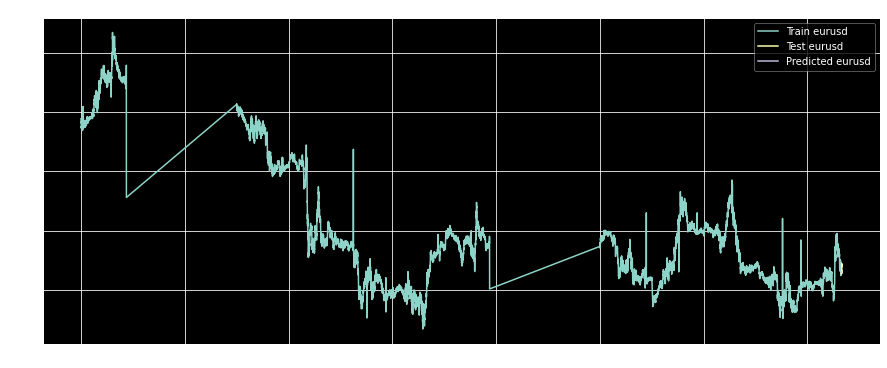

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

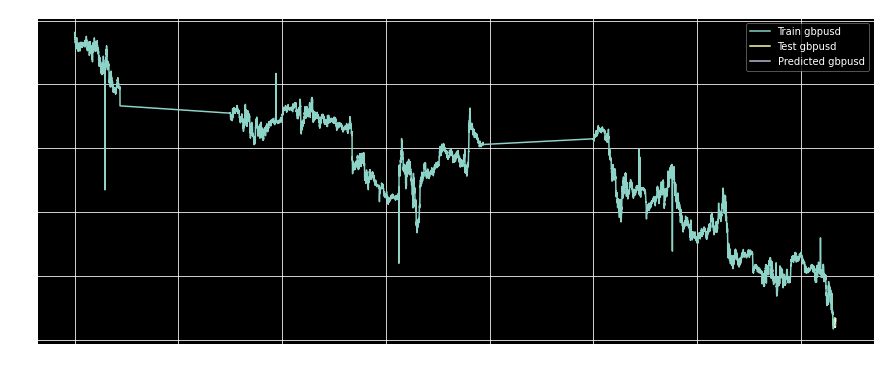

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

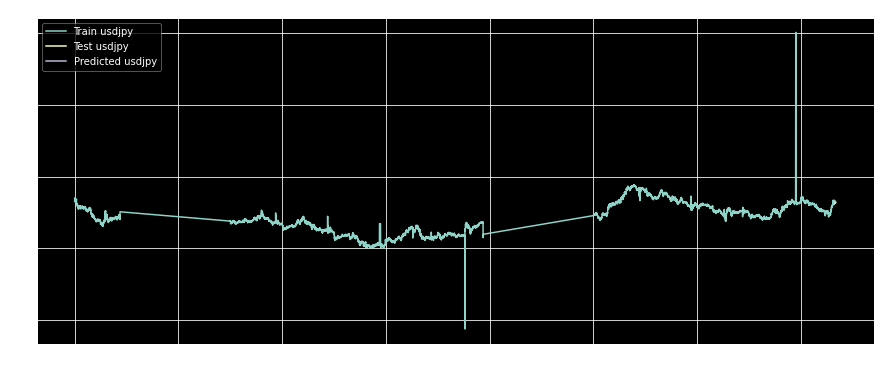

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

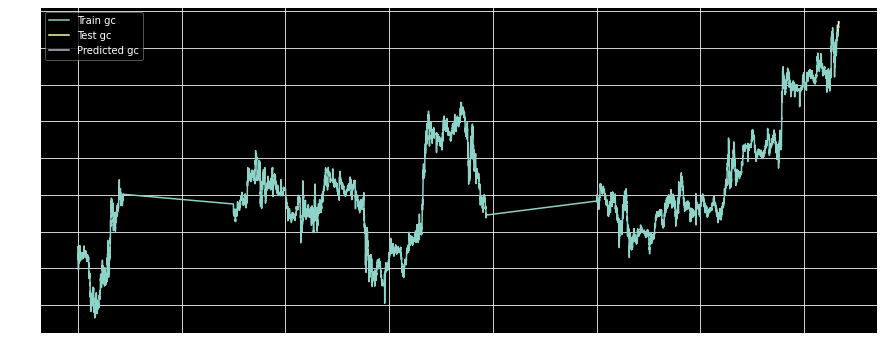

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

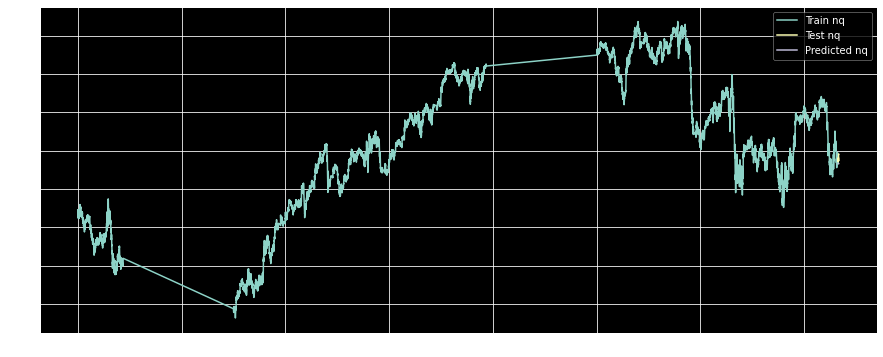

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

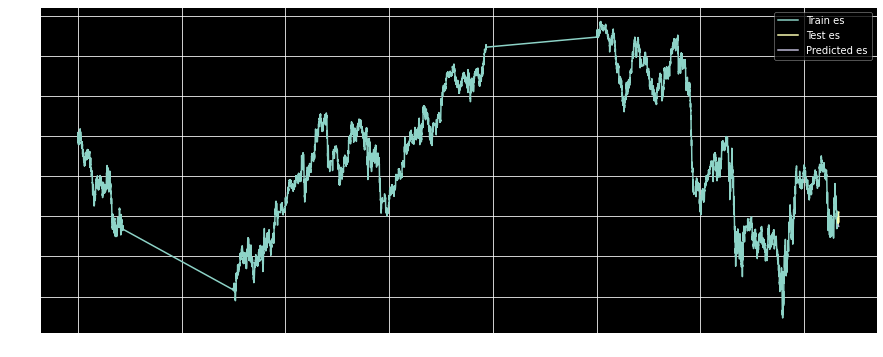

In [82]:
train_ecm, test_ecm = X[0:-nobs], X[-nobs:]

plt.style.use('dark_background')
get_ipython().run_line_magic('matplotlib', 'inline')
for i in ['eurusd','gbpusd','usdjpy','gc','nq','es']:
    plt.rcParams["figure.figsize"] = [15,6]
    plt.plot(train_ecm[str(i)], label='Train '+str(i))
    plt.plot(test_ecm[str(i)], label='Test '+str(i))
    plt.plot(forecast[str(i) + '_pred'], label='Predicted '+ str(i))
    plt.legend(loc='best')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

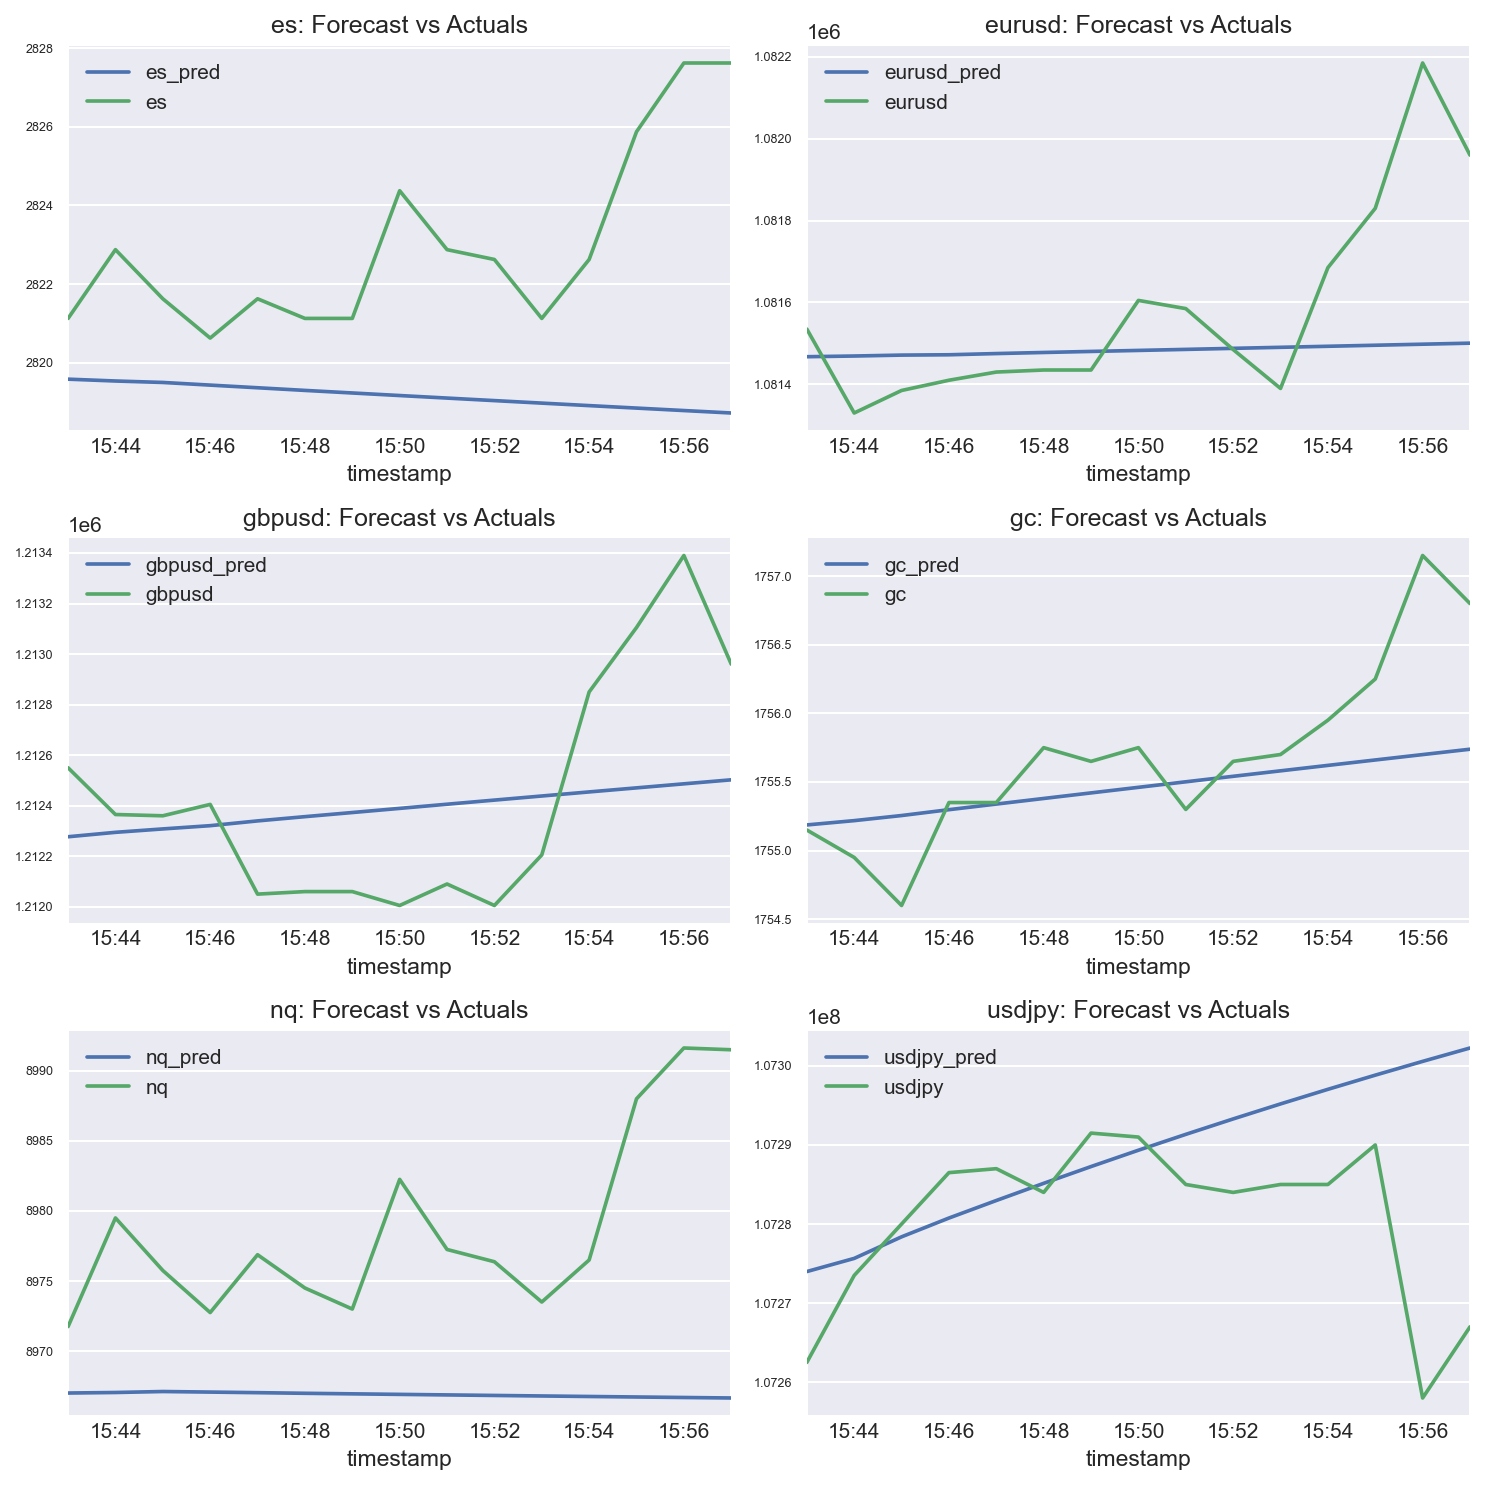

In [83]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    forecast[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_ecm[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


In [55]:
from statsmodels.tsa.vector_ar.vecm import VECM

# pass "1min" frequency
train_ecm.index = pd.DatetimeIndex(train_ecm.index).to_period('1min')

# VECM
vecm_1 = VECM(train_ecm, k_ar_diff=2, coint_rank = 4, deterministic='ci')

"""estimates the VECM on the prices with 8 lags, 2 cointegrating relationship, and 
a constant within the cointegration relationship"""

vecm_fit_1 = vecm_1.fit()

pd.options.display.float_format = "{:.2f}".format
fcast_1, lower, upper = vecm_fit_1.predict(nobs, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(2))
print("\npoint forecasts:")
print(fcast_1.round(2))
print("\nupper bounds of confidence intervals:")
print(upper.round(2))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

lower bounds of confidence intervals:
[[2.85179000e+03 1.08056004e+06 1.21945850e+06 1.74437000e+03
  9.11053000e+03 1.06995279e+08]
 [2.85077000e+03 1.08045388e+06 1.21931069e+06 1.74395000e+03
  9.10725000e+03 1.06955545e+08]
 [2.84996000e+03 1.08038802e+06 1.21923271e+06 1.74365000e+03
  9.10466000e+03 1.06924572e+08]
 ...
 [2.80371000e+03 1.07559229e+06 1.21444190e+06 1.72537000e+03
  8.96180000e+03 1.06351332e+08]
 [2.80367000e+03 1.07558845e+06 1.21443679e+06 1.72535000e+03
  8.96166000e+03 1.06351140e+08]
 [2.80362000e+03 1.07558461e+06 1.21443169e+06 1.72533000e+03
  8.96151000e+03 1.06350948e+08]]

point forecasts:
[[2.85412000e+03 1.08102511e+06 1.22017142e+06 1.74542000e+03
  9.11816000e+03 1.07124271e+08]
 [2.85412000e+03 1.08102455e+06 1.22016416e+06 1.74543000e+03
  9.11824000e+03 1.07126728e+08]
 [2.85409000e+03 1.08102884e+06 1.22020274e+06 1.74543000e+03
  9.11824000e+03 1.07128435e+08]
 ...
 [2.85127000e+03 1.08142505e+06 1.22182502e+06 1.74439000e+03
  9.12211000e+03

In [59]:
pd.options.display.float_format = "{:.2f}".format
fcast_1 = DataFrame(fcast_1, index= test_ecm.index, columns= test_ecm.columns)
fcast_1.rename(columns = {'eur_usd':'eur_usd_pred', 'gbp_usd':'gbp_usd_pred', 'usd_jpy':'usd_jpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
fcast_1

<IPython.core.display.Javascript object>

es_pred  eur_usd_pred  gbp_usd_pred  gc_pred  nq_pred  \
timestamp                                                                    
2020-05-15 07:38:00  2854.12    1081025.11    1220171.42  1745.42  9118.16   
2020-05-15 07:39:00  2854.12    1081024.55    1220164.16  1745.43  9118.24   
2020-05-15 07:40:00  2854.09    1081028.84    1220202.74  1745.43  9118.24   
2020-05-15 07:41:00  2854.07    1081029.64    1220207.87  1745.44  9118.24   
2020-05-15 07:42:00  2854.05    1081031.34    1220218.37  1745.44  9118.25   
...                      ...           ...           ...      ...      ...   
2020-05-15 15:53:00  2851.27    1081424.63    1221824.56  1744.40  9122.12   
2020-05-15 15:54:00  2851.27    1081424.84    1221824.79  1744.40  9122.12   
2020-05-15 15:55:00  2851.27    1081425.05    1221825.02  1744.39  9122.11   
2020-05-15 15:56:00  2851.26    1081425.25    1221825.24  1744.39  9122.11   
2020-05-15 15:57:00  2851.26    1081425.46    1221825.45  1744.38  9122.11   

                     usd_jpy_pred  
timestamp                          
2020-05-15 07:38:00  107124270.68  
2020-05-15 07:39:00  107126727.59  
2020-05-15 07:40:00  107128434.98  
2020-05-15 07:41:00  107130105.61  
2020-05-15 07:42:00  107131845.09  
...                           ...  
2020-05-15 15:53:00  107139600.88  
2020-05-15 15:54:00  107139576.76  
2020-05-15 15:55:00  107139552.90  
2020-05-15 15:56:00  107139529.28  
2020-05-15 15:57:00  107139505.91  

[500 rows x 6 columns]

In [60]:
join = concat([test_ecm, fcast_1], axis=1)
pred_1 = combine[['eur_usd', 'eur_usd_pred', 'gbp_usd', 'gbp_usd_pred', 'usd_jpy', 
                   'usd_jpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred_1.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eur_usd_pred', 'gbp_usd_pred', 'usd_jpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

<IPython.core.display.Javascript object>

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
r_squared = r2_score(pred_1.eur_usd, pred_1.eur_usd_pred)
mae = mean_absolute_error(pred_1.eur_usd, pred_1['eur_usd_pred'])
mse = mean_squared_error(pred_1.eur_usd, pred_1.eur_usd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.eur_usd, pred_1.eur_usd_pred)
sum_df = DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean squared log Error'])
sum_df['Accuracy metrics :    EURUSD'] = [r_squared, mae, mse, rmse, msle]

# score gbp_usd
r_squared = r2_score(pred_1.gbp_usd, pred_1.gbp_usd_pred)
mae = mean_absolute_error(pred_1.gbp_usd, pred_1['gbp_usd_pred'])
mse = mean_squared_error(pred_1.gbp_usd, pred_1.gbp_usd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.gbp_usd, pred_1.gbp_usd_pred)
sum_df['GBPUSD'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_1.usd_jpy, pred_1.usd_jpy_pred)
mae = mean_absolute_error(pred_1.usd_jpy, pred_1['usd_jpy_pred'])
mse = mean_squared_error(pred_1.usd_jpy, pred_1.usd_jpy_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.usd_jpy, pred_1.usd_jpy_pred)
sum_df['USDJPY'] = [r_squared, mae, mse, rmse, msle]

# score nq
r_squared = r2_score(pred_1.nq, pred_1.nq_pred)
mae = mean_absolute_error(pred_1.nq, pred_1['nq_pred'])
mse = mean_squared_error(pred_1.nq, pred_1.nq_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.nq, pred_1.nq_pred)
sum_df['NQ'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_1.es, pred_1.es_pred)
mae = mean_absolute_error(pred_1.es, pred_1['es_pred'])
mse = mean_squared_error(pred_1.es, pred_1.es_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.es, pred_1.es_pred)
sum_df['ES'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_1.gc, pred_1.gc_pred)
mae = mean_absolute_error(pred_1.gc, pred_1['gc_pred'])
mse = mean_squared_error(pred_1.gc, pred_1.gc_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_1.gc, pred_1.gc_pred)
sum_df['GC'] = [r_squared, mae, mse, rmse, msle]
sum_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics :    EURUSD      GBPUSD  \
R-squared                                       -0.18       -1.30   
Mean Absolute Error                           1000.21     3420.13   
Mean squared error                         1879166.16 20646930.87   
Root mean squared error                       1370.83     4543.89   
Mean squared log Error                           0.00        0.00   

                                USDJPY       NQ     ES    GC  
R-squared                        -0.84    -1.61  -1.21  0.07  
Mean Absolute Error          135362.94    88.63  18.40  4.08  
Mean squared error      21674705577.13 12225.09 515.12 21.93  
Root mean squared error      147223.32   110.57  22.70  4.68  
Mean squared log Error            0.00     0.00   0.00  0.00

In [78]:
# VECM
vecm_2 = VECM(train_ecm, k_ar_diff=8, coint_rank = 2, deterministic='cili')

"""estimates the VECM on the prices with 8 lags, 2 cointegrating relationship, and 
a constant within the cointegration relationship"""

vecm_fit_2 = vecm_2.fit()

pd.options.display.float_format = "{:.2f}".format
fcast_2, lower, upper = vecm_fit_2.predict(nobs, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(2))
print("\npoint forecasts:")
print(fcast_2.round(2))
print("\nupper bounds of confidence intervals:")
print(upper.round(2))

<IPython.core.display.Javascript object>

lower bounds of confidence intervals:
[[2.85178000e+03 1.08056543e+06 1.21951703e+06 1.74439000e+03
  9.11042000e+03 1.06996112e+08]
 [2.85064000e+03 1.08047533e+06 1.21942241e+06 1.74395000e+03
  9.10682000e+03 1.06958696e+08]
 [2.84979000e+03 1.08040387e+06 1.21928114e+06 1.74367000e+03
  9.10404000e+03 1.06926958e+08]
 ...
 [2.80061000e+03 1.07558293e+06 1.21447305e+06 1.72678000e+03
  8.94607000e+03 1.06556972e+08]
 [2.80056000e+03 1.07557750e+06 1.21446808e+06 1.72676000e+03
  8.94589000e+03 1.06556858e+08]
 [2.80050000e+03 1.07557209e+06 1.21446311e+06 1.72674000e+03
  8.94572000e+03 1.06556744e+08]]

point forecasts:
[[2.85411000e+03 1.08102657e+06 1.22022654e+06 1.74544000e+03
  9.11804000e+03 1.07124891e+08]
 [2.85399000e+03 1.08103500e+06 1.22026786e+06 1.74542000e+03
  9.11781000e+03 1.07129381e+08]
 [2.85392000e+03 1.08102317e+06 1.22023401e+06 1.74544000e+03
  9.11762000e+03 1.07130033e+08]
 ...
 [2.85150000e+03 1.08113097e+06 1.22134195e+06 1.74716000e+03
  9.11821000e+03

In [79]:
pd.options.display.float_format = "{:.2f}".format
fcast_2 = DataFrame(fcast_2, index= test_ecm.index, columns= test_ecm.columns)
fcast_2.rename(columns = {'eur_usd':'eur_usd_pred', 'gbp_usd':'gbp_usd_pred', 'usd_jpy':'usd_jpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
join = concat([test_ecm, fcast_2], axis=1)
pred_2 = combine[['eur_usd', 'eur_usd_pred', 'gbp_usd', 'gbp_usd_pred', 'usd_jpy', 
                   'usd_jpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred_2.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eur_usd_pred', 'gbp_usd_pred', 'usd_jpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
r_squared = r2_score(pred_2.eur_usd, pred_2.eur_usd_pred)
mae = mean_absolute_error(pred_2.eur_usd, pred_2['eur_usd_pred'])
mse = mean_squared_error(pred_2.eur_usd, pred_2.eur_usd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.eur_usd, pred_2.eur_usd_pred)
sum_df = DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean squared log Error'])
sum_df['Accuracy metrics :    EURUSD'] = [r_squared, mae, mse, rmse, msle]

# score gbp_usd
r_squared = r2_score(pred_2.gbp_usd, pred_2.gbp_usd_pred)
mae = mean_absolute_error(pred_2.gbp_usd, pred_2['gbp_usd_pred'])
mse = mean_squared_error(pred_2.gbp_usd, pred_2.gbp_usd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.gbp_usd, pred_2.gbp_usd_pred)
sum_df['GBPUSD'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_2.usd_jpy, pred_2.usd_jpy_pred)
mae = mean_absolute_error(pred_2.usd_jpy, pred_2['usd_jpy_pred'])
mse = mean_squared_error(pred_2.usd_jpy, pred_2.usd_jpy_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.usd_jpy, pred_2.usd_jpy_pred)
sum_df['USDJPY'] = [r_squared, mae, mse, rmse, msle]

# score nq
r_squared = r2_score(pred_2.nq, pred_2.nq_pred)
mae = mean_absolute_error(pred_2.nq, pred_2['nq_pred'])
mse = mean_squared_error(pred_2.nq, pred_2.nq_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.nq, pred_2.nq_pred)
sum_df['NQ'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_2.es, pred_2.es_pred)
mae = mean_absolute_error(pred_2.es, pred_2['es_pred'])
mse = mean_squared_error(pred_2.es, pred_2.es_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.es, pred_2.es_pred)
sum_df['ES'] = [r_squared, mae, mse, rmse, msle]

# score usd_jpy
r_squared = r2_score(pred_2.gc, pred_2.gc_pred)
mae = mean_absolute_error(pred_2.gc, pred_2['gc_pred'])
mse = mean_squared_error(pred_2.gc, pred_2.gc_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred_2.gc, pred_2.gc_pred)
sum_df['GC'] = [r_squared, mae, mse, rmse, msle]
sum_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics :    EURUSD      GBPUSD  \
R-squared                                       -0.18       -1.30   
Mean Absolute Error                           1000.21     3420.13   
Mean squared error                         1879166.16 20646930.87   
Root mean squared error                       1370.83     4543.89   
Mean squared log Error                           0.00        0.00   

                                USDJPY       NQ     ES    GC  
R-squared                        -0.84    -1.61  -1.21  0.07  
Mean Absolute Error          135362.94    88.63  18.40  4.08  
Mean squared error      21674705577.13 12225.09 515.12 21.93  
Root mean squared error      147223.32   110.57  22.70  4.68  
Mean squared log Error            0.00     0.00   0.00  0.00

In [84]:
# VECM
vecm_3 = VECM(train_ecm, k_ar_diff=4, coint_rank = 4)

"""estimates the VECM on the prices with 8 lags, 2 cointegrating relationship, and 
a constant within the cointegration relationship"""

vecm_fit_3 = vecm_3.fit()

pd.options.display.float_format = "{:.2f}".format
fcast_3, lower, upper = vecm_fit_3.predict(nobs, 0.05)
#print("lower bounds of confidence intervals:")
#print(lower.round(2))
#print("\npoint forecasts:")
#print(fcast_3.round(2))
#print("\nupper bounds of confidence intervals:")
#print(upper.round(2))

pd.options.display.float_format = "{:.2f}".format
fcast_3 = DataFrame(fcast_3, index= test_ecm.index, columns= test_ecm.columns)
fcast_3.rename(columns = {'eur_usd':'eur_usd_pred', 'gbp_usd':'gbp_usd_pred', 'usd_jpy':'usd_jpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
join = concat([test_ecm, fcast_3], axis=1)
pred_3 = combine[['eur_usd', 'eur_usd_pred', 'gbp_usd', 'gbp_usd_pred', 'usd_jpy', 
                   'usd_jpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred_3.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eur_usd_pred', 'gbp_usd_pred', 'usd_jpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

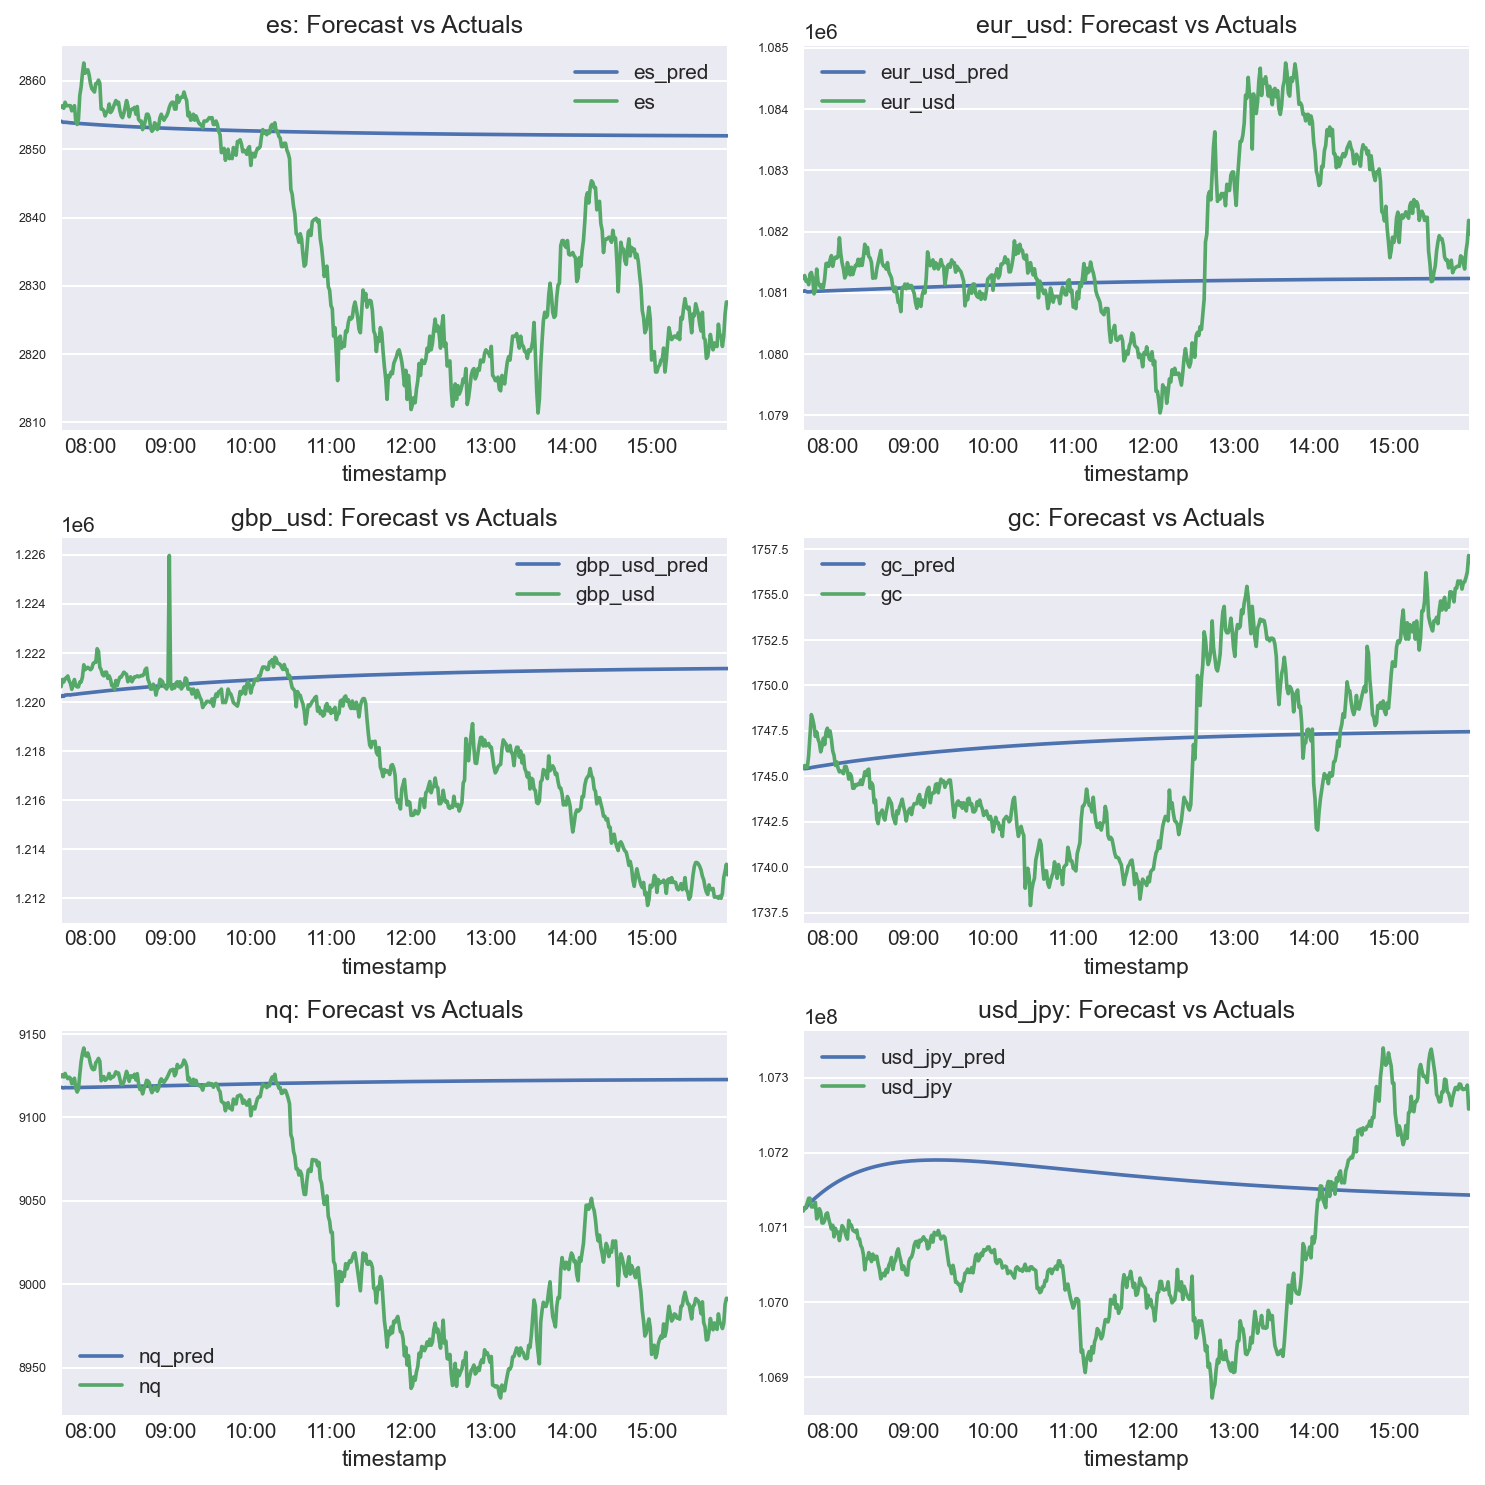

In [85]:
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pred_3[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_ecm[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();